Homework 2: Graph Neural Network for chemistry

2) Graph neural networks for molecules (GCN)
- experiment GCN from the deepchem python library
- understand the GCN structure and learning (see GNN course slides)
- test it on several supervised datasets, in order the make node classification or graph classification
- evaluate (explain the measures) and discuss the results


In [5]:
!pip install --pre deepchem

We make a first test the DeepChem library with the code mentioned in the tutorial. We load the Tox21 dataset with the featurizer 'GraphConv'.

In [6]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/home/leon/anaconda3/lib/python3.11/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
2024-12-19 09:57:03.600275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 09:57:04.049537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 09:57:07.289079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading modules with pytorch-geometric dependency, missing 

Train the graph convolutional network for classification with GraphConvModel

In [13]:
n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification', batch_normalize=False)
model.fit(train_dataset, nb_epoch=50)

0.30834794998168946

Evaluate the performance of the model. We use the metric ROC-AUC score (tradeoff between precision and recall).

In [14]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('Training set score:', model.evaluate(train_dataset, [metric], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric], transformers))

Training set score: {'roc_auc_score': 0.9662236418729662}
Test set score: {'roc_auc_score': 0.7141046267308472}


Let's use the SIRTUIN6 Small Molecules dataset, for classification, which includes 100 molecules with descriptors to determine the candidate inhibitors of a target protein. The molecules are grouped based on low- and high-BFE which we use for the classification.
Link to the dataset:
https://archive.ics.uci.edu/dataset/748/sirtuin6+small+molecules-1

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
#import sirtuin6 dataset
df = pd.read_csv('data/SIRTUIN6.csv')
X = df.drop('Class', axis=1).values
y = (df['Class'] == 'High_BFE').astype(int)

In [9]:
#split data between train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

train_dataset = dc.data.NumpyDataset(X_train_scaled, y_train)
test_dataset = dc.data.NumpyDataset(X_test_scaled, y_test)

In [10]:
n_features = X_train.shape[1]
model = dc.models.MultitaskClassifier(n_tasks=1, n_features=n_features, layer_sizes=[64, 32], dropout=0.2)

#train the model
model.fit(train_dataset, nb_epoch=50)

0.7293518829345703

In [11]:
y_pred_proba = model.predict(test_dataset)

In [12]:
#we convert the probabilities to class predictions to solve issues with shape
y_pred_classes = np.argmax(y_pred_proba, axis=2)
y_pred_classes = y_pred_classes.flatten()
y_test_flat = y_test.flatten()

We perform evaluation on the regular measures for models with the function classification_report from sklearn.metrics. It covers precision, recall, f1-score and support for the classes.  
- Precision : measures the accuracy of positive predictions.
- Recall : measures the ability of the model to find all positive samples.
- f1-score : mean of precision and recall.
- suport : number of true samples in each class.


In [13]:
print(classification_report(y_test_flat, y_pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.82      0.75      0.78        12

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20



We can also print the confusion matrix which compares the predicted labels with the true labels.

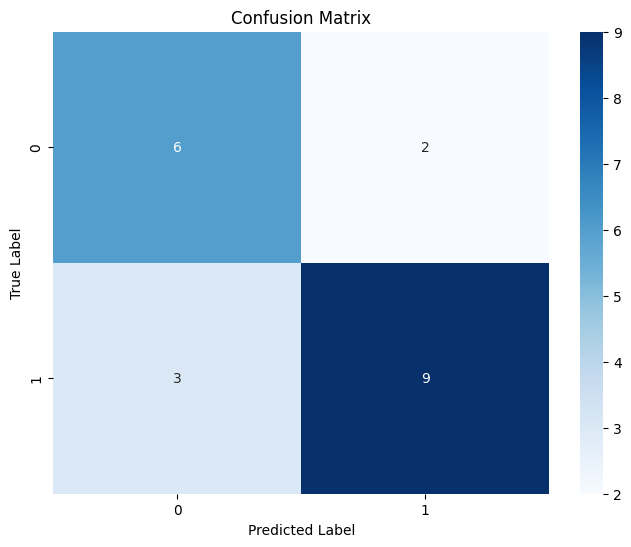

In [14]:
cm = confusion_matrix(y_test_flat, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()